In [1]:
from typing import Callable

import numpy as np
import matplotlib.gridspec as gs
from ezephys import stimtools as st
from ezephys import pltools
import matplotlib.pyplot as plt
from scipy.signal import lfilter


In [2]:
# experiment wide parameters
dt = 0.1

In [3]:
def DesignExponentialFilter(tau_ms, filter_length_ms):
  t = np.arange(0, filter_length_ms, dt)
  IRF_filter = np.exp(-t / tau_ms)
  IRF_filter = IRF_filter/sum(IRF_filter)
  IRF_filter[0] = 0
  return IRF_filter, t

def get_sigmoid(loc: float, sensitivity: float, gain: float) -> Callable[[np.ndarray], np.ndarray]:
    def sigmoid(x):
        return gain / (1 + np.exp(-(x - loc) / sensitivity))
    return sigmoid

def get_filter(kernel: np.ndarray) -> Callable[[np.ndarray], np.ndarray]:
  """Get a function that convolves the kernel with an input."""
  return lambda input_: lfilter(kernel, 1, input_, axis=-1, zi=None)

def get_linear_nonlinear_model(
  membrane_kernel: np.ndarray, sodium_kernel: np.ndarray, sigmoid: np.ndarray
) -> Callable[[np.ndarray], np.ndarray]:
  membrane_filter = get_filter(membrane_kernel)
  sodium_filter = get_filter(sodium_kernel)

  def linear_nonlinear_model(dendritic_input: np.ndarray) -> np.ndarray:
    assert np.ndim(dendritic_input) == 1

    return sigmoid(sodium_filter(dendritic_input)) + membrane_filter(dendritic_input)
    
  return linear_nonlinear_model

In [4]:
def delayed_pulse(delay_ms: float, peak_amplitude: float, total_duration: float = 100.) -> st.ConvolvedStimulus:
    """Create ConvolvedStimulus containing a synaptic pulse with a delayed start."""
    synaptic_kernel = st.BiexponentialSynapticKernel(peak_amplitude, 0.1, 5, duration=25., dt=dt)

    pulse_time = np.zeros(int(total_duration / dt - 0.5))
    pulse_time[int(delay_ms / dt - 0.5)] = 1.
    pulse = st.ConvolvedStimulus(0, synaptic_kernel)
    pulse.generate(pulse_time, dt)
    return pulse

In [5]:
membrane_kernel, _ = DesignExponentialFilter(tau_ms=10, filter_length_ms=100)
sodium_kernel, _ = DesignExponentialFilter(tau_ms=5, filter_length_ms=100)

# model parameters
na_nonlinear_baseline = 1.4
na_nonlinear_sensitivity = 0.2
na_nonlinear_gain = 35

membrane_filter_gain = 35

sigmoid = get_sigmoid(na_nonlinear_baseline, na_nonlinear_sensitivity, na_nonlinear_gain)
sodium_filter = get_filter(sodium_kernel)
membrane_filter = get_filter(membrane_kernel)

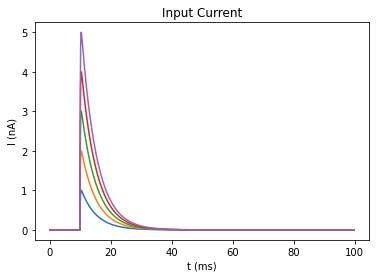

In [6]:
plt.figure()
plt.ylabel('I (nA)')
plt.xlabel('t (ms)')
window_duration_ms = 100
plt.title('Input Current')
t = [(i * dt) for i in range(int(window_duration_ms / dt - 0.5))]
for current_peak_nA in range(1, 6):
    dend_pulse = delayed_pulse(delay_ms=10, peak_amplitude=current_peak_nA, total_duration=window_duration_ms)
    plt.plot(t, dend_pulse.command.flatten())

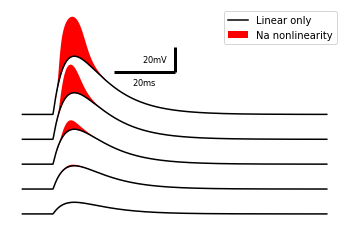

In [7]:
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('V_d (mV)')

for i, current_peak_nA in enumerate(range(1, 6)):
    dend_pulse = delayed_pulse(delay_ms=10, peak_amplitude=current_peak_nA, total_duration=window_duration_ms)

    V_membrane = membrane_filter_gain * membrane_filter(dend_pulse.command.flatten())

    input_na_lfiltered = sodium_filter(dend_pulse.command.flatten())
    V_na = sigmoid(input_na_lfiltered)

    na_fill = plt.fill_between(t, 20 * i + V_membrane, 20 * i + V_membrane + V_na, color='r', linewidth=0)
    linear_line = plt.plot(t, 20 * i + V_membrane, 'k-')[0]

pltools.add_scalebar(x_units='ms', y_units='mV', anchor=(0.5, 0.7), bar_space=0)
linear_line.set_label('Linear only')
na_fill.set_label('Na nonlinearity')
plt.legend()

del na_fill, linear_line

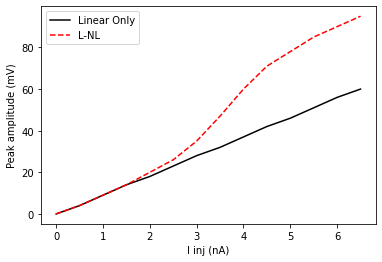

In [8]:
window_duration_ms = 100
plt.figure()
plt.xlabel('I inj (nA)')
plt.ylabel('Peak amplitude (mV)')

I_peak_nA_iterator = np.arange(0, 7, 0.5)
voltage_peak_mV_na = np.array([0 for i in range(len(I_peak_nA_iterator))])
voltage_peak_mV_linear_only = np.array([0 for i in range(len(I_peak_nA_iterator))])

for i in range(len(I_peak_nA_iterator)):
    I_peak_nA = I_peak_nA_iterator[i]

    dend_pulse = delayed_pulse(delay_ms=10, peak_amplitude=I_peak_nA)

    V_membrane = membrane_filter_gain * membrane_filter(dend_pulse.command.flatten())

    input_na_lfiltered = sodium_filter(dend_pulse.command.flatten())
    V_na = sigmoid(input_na_lfiltered)

    voltage_peak_mV_na[i] = V_membrane.max()
    voltage_peak_mV_linear_only[i] = (V_membrane + V_na).max()

plt.plot(I_peak_nA_iterator, voltage_peak_mV_na, 'k-')
plt.plot(I_peak_nA_iterator, voltage_peak_mV_linear_only, 'r--')
plt.legend(['Linear Only', 'L-NL'])

## Thoughts
- The supra linear responses due to the non linearity of sodium spikes seem to be fatter than experimental data, maybe I need to tweak my parameters
- Makes sense because the sigmoid gives a "ceiling" like effect for values above saturation threshold